In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monodepthloss
from depthencoder import depthencoder 
from depth_decoder import *
DEVICE = torch.device("cuda:0")
# Moving to the gpu: net = Net().to(DEVICE)

In [2]:
x = torch.randn(4, 3,640,256).to(DEVICE)
encoderdecoder = DepthDecoder().to(DEVICE)
xout = encoderdecoder(x.view(-1,3,640,256))
for key in xout.keys():
    print(f"{key} is {xout[key].size()}")


('disp', 3) is torch.Size([4, 1, 80, 32])
('disp', 2) is torch.Size([4, 1, 160, 64])
('disp', 1) is torch.Size([4, 1, 320, 128])
('disp', 0) is torch.Size([4, 1, 640, 256])


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import movieparser
import os
import time
from torchvision.utils import save_image
import torchvision

images = os.listdir('left/skyscraper')

optimizer = optim.Adam(encoderdecoder.parameters(),lr=0.0001) 

frames = list(range(len(images)))
frames = frames[1200:-10900] # Remove meaningless title/credit images.

batch_size = 4
results = []
# network.load_state_dict(torch.load('model2.t'))
# for epoch in range(EPOCHS):
random.shuffle(frames)
frame_subset = []
blockofframes = []
for i, frame in enumerate(frames):
    frame_subset.append(frame)
    if (i+1) % batch_size == 0:
        blockofframes.append(frame_subset)
        frame_subset = []

  3%|▎         | 1000/33803 [15:29<8:09:19,  1.12it/s]

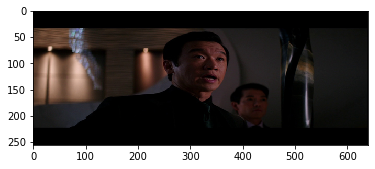

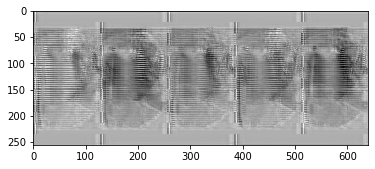

In [4]:
testing = False
j = 0
mean = []
f= open(f"logs/results-{int(time.time())}.txt","w+")
for frameset in tqdm(blockofframes):
    _, LinN, _, _, RoutN, _ = movieparser.getframeset(frameset, images)
    # LinNm, LinN, LinNp, RoutNm, RoutN, RoutNp = movieparser.getframeset(frameset, images)
    
    encoderdecoder.zero_grad()
    output1 = encoderdecoder(LinN.type(torch.cuda.FloatTensor))
    output2 = encoderdecoder(RoutN.type(torch.cuda.FloatTensor))
    
    '''output1 = encoderdecoder(torch.cat([LinNm.type(torch.cuda.FloatTensor), \
                     LinN.type(torch.cuda.FloatTensor), \
                     LinNp.type(torch.cuda.FloatTensor)], 1))
    output2 = encoderdecoder(torch.cat([RoutNm.type(torch.cuda.FloatTensor), \
                     RoutN.type(torch.cuda.FloatTensor), \
                     RoutNp.type(torch.cuda.FloatTensor)], 1))'''
    
    if(j == 1000):
        plt.imshow(RoutN[1].cpu().view(3, 256, 640).permute(1, 2, 0))
        plt.show()
        plt.imshow(output1[('disp', 0)][1].view(256, 640).cpu().detach().numpy(), 'gray')
        plt.show()
        break
    
    loss_function = monodepthloss.MonodepthLoss(n=4, SSIM_w=0.85,\
            disp_gradient_w=0.1, lr_w=1).to(DEVICE)
    output = []
    for i in output1.keys():
        output.append(torch.cat((output1[i], output2[i]), 1))
    loss = loss_function(output,[LinN.type(torch.cuda.FloatTensor),\
                                 RoutN.type(torch.cuda.FloatTensor)])
    loss.backward()
    mean.append(loss.item())
    if j % 100 == 0:
        f.write(f"{round(sum(mean)/len(mean),5)}\n")
        f.flush()
        results.append(sum(mean)/len(mean))
        mean = []
    j += 1
    if j % 10000 == 0:
        thetime = int(time.time())
        torch.save(encoderdecoder.state_dict(), f"encoderdecoder-{thetime}")
        save_image(RoutN[0].cpu().view(3, 720, 1280), \
                   f'imageout/right-{thetime}.png')
        save_image(output1[('disp', 0)][0].view(720, 1280).cpu(), \
                   f'imageout/depth-{thetime}.png')
    optimizer.step()
f.close()

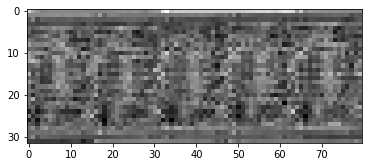

In [5]:
plt.imshow(output1[('disp', 3)][1].view(256//8, 640//8).cpu().detach().numpy(), 'gray')
plt.show()

In [6]:
output1[('disp', 3)][0]

tensor([[[0.5729, 0.5531, 0.5434,  ..., 0.5397, 0.5451, 0.5449],
         [0.5850, 0.5977, 0.5667,  ..., 0.5777, 0.5774, 0.5761],
         [0.5464, 0.5687, 0.5359,  ..., 0.5392, 0.5422, 0.5369],
         ...,
         [0.5186, 0.5241, 0.5063,  ..., 0.4823, 0.4933, 0.4962],
         [0.5433, 0.5367, 0.5329,  ..., 0.5084, 0.5158, 0.4991],
         [0.5425, 0.5352, 0.5245,  ..., 0.5179, 0.5285, 0.5231]]],
       device='cuda:0', grad_fn=<SelectBackward>)